In [ ]:
import numpy as np
import pickle
import random

class TicTacToe:
    def __init__(self, n=3):
        self.n = n
        self.board = np.zeros((n, n), dtype=int)
        self.reset()

    def reset(self):
        self.board = np.zeros((self.n, self.n), dtype=int)
        return self.board

    def available_actions(self):
        return [(i, j) for i in range(self.n) for j in range(self.n) if self.board[i, j] == 0]

    def make_move(self, row, col, player):
        if self.board[row, col] == 0:
            self.board[row, col] = player
            return True
        return False

    def check_winner(self):
        for i in range(self.n):
            if np.all(self.board[i, :] == 1) or np.all(self.board[:, i] == 1):
                return 1
            if np.all(self.board[i, :] == -1) or np.all(self.board[:, i] == -1):
                return -1
        
        if np.all(np.diag(self.board) == 1) or np.all(np.diag(np.fliplr(self.board)) == 1):
            return 1
        if np.all(np.diag(self.board) == -1) or np.all(np.diag(np.fliplr(self.board)) == -1):
            return -1

        if not any(0 in row for row in self.board):
            return 0

        return None

    def is_draw(self):
        return not any(0 in row for row in self.board)

    def get_state(self):
        return self.board

class QLearningAgent:
    def __init__(self, n=3, alpha=0.9, gamma=1, epsilon=0.1):
        self.n = n
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}  

    def get_hash(self, state):
        return ' '.join(map(str, (state.reshape(self.n * self.n))))

    def choose_action(self, state, available_actions):
        hash_state = self.get_hash(state)
        if random.uniform(0, 1) < self.epsilon or hash_state not in self.q_table.keys() or len(self.q_table[hash_state]) > 0:
            return random.choice(available_actions)
        else:
            max_q = -1
            best_action = None
            for (action, value) in self.q_table[self.get_hash(state)].items():
                if value > max_q:
                    max_q = value
                    best_action = action
            assert(best_action != None)
            return best_action

    def update_q_value(self, state, action, reward, next_state, done):
        state_hash = self.get_hash(state)
        if state_hash not in self.q_table:
            self.q_table[state_hash] = {}  
        
        current_q = 0
        if action in self.q_table[state_hash]:
            current_q = self.q_table[state_hash][action]            
        
        max_future_q = 0
        next_state_hash = self.get_hash(next_state)
        if next_state_hash in self.q_table.keys() and len(self.q_table[next_state_hash].values()) > 0:
            max_future_q = max(self.q_table[next_state_hash].values())

        if done:
            self.q_table[state_hash][action] = current_q + self.alpha * (reward - current_q)
        else:
            self.q_table[state_hash][action] = current_q + self.alpha * (reward + self.gamma * max_future_q - current_q)
   
    def savePolicy(self, name):
        fw = open(name, 'wb')
        pickle.dump(self.q_table, fw)
        fw.close()

    def loadPolicy(self, file):
        fr = open(file, 'rb')
        self.q_table = pickle.load(fr)
        fr.close()


def train(agent, env, episodes=10000):
    win, draw, lose = 0, 0, 0
    for episode in range(episodes):
        if episode % (episodes//10) == 0:
            print("Running at: ", episode)
            print(f"Win: {win}| Draw: {draw}| Lose: {lose}")
        state = env.reset()
        done = False
        while not done:
            available_actions = env.available_actions()
            action = agent.choose_action(env.get_state(), available_actions)
            env.make_move(action[0], action[1], 1)
            
            next_state = env.get_state()
            winner = env.check_winner()

            if winner == 1:
                reward = 10
                done = True
            elif winner == -1:
                reward = -10
                done = True
            elif env.is_draw():
                reward = 0
                done = True
            else:
                reward = 0

            

            if not done:
                available_actions = env.available_actions()
                if available_actions:
                    action = random.choice(available_actions)
                    env.make_move(action[0], action[1], -1)
                    winner = env.check_winner()
                    next_state = env.get_state()
                    if winner == 1:
                        reward = 10
                        done = True
                    elif winner == -1:
                        reward = -10
                        done = True
                    elif env.is_draw():
                        reward = 0
                        done = True
                    else:
                        reward = 0
                    agent.update_q_value(state, action, reward, next_state, done)
                    state = next_state
                state = next_state
            else:
                agent.update_q_value(state, action, reward, next_state, done)
        winner = env.check_winner()
        if winner > 0:
            win += 1
        elif winner == 0:
            draw += 1
        else:
            lose += 1
    return win, draw, lose



In [2]:
board_size = 4
env = TicTacToe(n=board_size)
agent = QLearningAgent(n=board_size)
episodes = 100000
win_percentage, draw_percentage, lose_percentage = train(agent, env, episodes=episodes)
print(win_percentage)
print(draw_percentage)
print(lose_percentage)
agent.savePolicy('policy')

Running at:  0
Win: 0| Draw: 0| Lose: 0
Running at:  10000
Win: 3147| Draw: 4106| Lose: 2747
Running at:  20000
Win: 6321| Draw: 8241| Lose: 5438
Running at:  30000
Win: 9474| Draw: 12347| Lose: 8179
Running at:  40000
Win: 12696| Draw: 16379| Lose: 10925
Running at:  50000
Win: 15885| Draw: 20489| Lose: 13626
Running at:  60000
Win: 19000| Draw: 24721| Lose: 16279
Running at:  70000
Win: 22102| Draw: 28897| Lose: 19001
Running at:  80000
Win: 25255| Draw: 33070| Lose: 21675
Running at:  90000
Win: 28374| Draw: 37239| Lose: 24387
31585
41380
27035


In [3]:
board_size = 4
env = TicTacToe(n=board_size)
agent = QLearningAgent(n=board_size)
agent.loadPolicy('policy')
episodes = 100
win_percentage, draw_percentage, lose_percentage = train(agent, env, episodes=episodes)

Running at:  0
Win: 0| Draw: 0| Lose: 0
Running at:  10
Win: 3| Draw: 3| Lose: 4
Running at:  20
Win: 6| Draw: 7| Lose: 7
Running at:  30
Win: 11| Draw: 12| Lose: 7
Running at:  40
Win: 15| Draw: 16| Lose: 9
Running at:  50
Win: 18| Draw: 20| Lose: 12
Running at:  60
Win: 21| Draw: 25| Lose: 14
Running at:  70
Win: 23| Draw: 29| Lose: 18
Running at:  80
Win: 26| Draw: 35| Lose: 19
Running at:  90
Win: 28| Draw: 37| Lose: 25


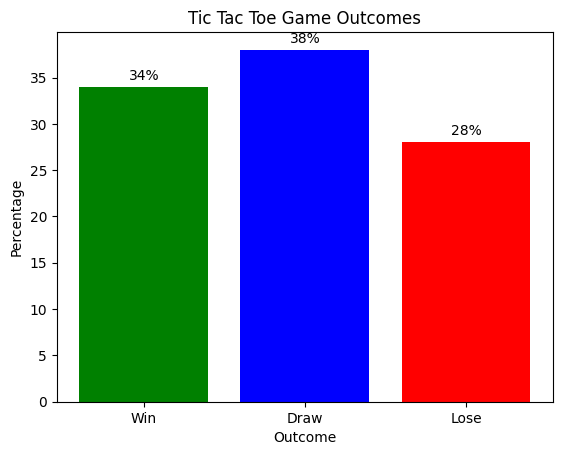

In [4]:
import matplotlib.pyplot as plt
labels = ['Win', 'Draw', 'Lose']

percentages = [win_percentage, draw_percentage, lose_percentage]

fig, ax = plt.subplots()
bars = ax.bar(labels, percentages, color=['green', 'blue', 'red'])

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}%', 
                xy=(bar.get_x() + bar.get_width() / 2, height), 
                xytext=(0, 3),  
                textcoords="offset points", 
                ha='center', va='bottom')

plt.xlabel('Outcome')
plt.ylabel('Percentage')
plt.title('Tic Tac Toe Game Outcomes')

plt.show()